# Recurrent neural networks

(This example is based on a lecture from EE-559 – Deep learning by Francois Fleuret,
an [excellent resource](https://documents.epfl.ch/users/f/fl/fleuret/www/dlc/).)

A recurrent model maintains a recurrent state that is updated at each time
step. Given a sequence $x$ and an initial recurrent state $h_0$ the model
computes a sequence of recurrent states:
$$
h_t = \Phi(x_t, h_{t-1}), \mathsf{with\ } t = 1, 2, 3, ...
$$

We will try and solve the problem of deciding if a sequence is a mirror of itself or not
using recurrent neural networks.

| sequence | label |
|----------|-------|
| (1,2, 1,2) | 1 |
| (3,4, 5,6) | 0 |
| (7, 7)     | 1 |
| (6,4,2, 6,4,2) | 1 |

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from collections import Counter

import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from keras.utils import to_categorical


def is_mirrored(x):
    return np.allclose(x[:x.shape[0]//2], x[-x.shape[0]//2:])


def generate_data(n_samples=100, max_length=10):
    """Generate sequences that are mirrored or not.
    
    You will not receive `n_samples` number of samples
    because sometimes a duplicate sequence is generated
    that we remove.
    
    `max_length` sets the maximum length a sequence can
    have. For each sequence a length is picked at random
    between 1 and `max_length`.
    """
    X = []
    y = []
    seqs = set()
    for _ in range(n_samples):
        n = np.random.randint(1, max_length+1)
        seq = np.zeros(max_length)
        seq[:n] = np.random.randint(0, 10, size=n)
        seq = np.hstack([seq, seq])

        if np.random.rand() > 0.5:
            np.random.shuffle(seq)

        if tuple(seq.tolist()) in seqs:
            continue

        seqs.add(tuple(seq.tolist()))
        X.append(to_categorical(seq, 10))
        y.append(is_mirrored(X[-1]))
        
    y = np.array(y, dtype=int)
    y_binary = to_categorical(y, 2)
    return np.array(X, dtype=float), y_binary, Counter(seqs)

Using TensorFlow backend.


## Generate data

Generate a dataset with a lot of entries. It is a good idea to get everything
running with a small dataset, and then increase it. This way you don't spend
too much time waiting for errors that only occur after training.

Split your data into a training and testing set.

In [3]:
X, y, counter = generate_data(30000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [4]:
len(counter)

25326

In [5]:
X_train.shape

(20260, 20, 10)

In [6]:
X_train[:2]

array([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

In [7]:
# check that the dataset is roughly balanced
Counter(y_train[:,0])

Counter({1.0: 11358, 0.0: 8902})

In [8]:
from keras.layers import SimpleRNN, Input
from keras.layers import LSTM
from keras.layers import Activation, Dense
from keras.models import Model

In [9]:
# make sure you understand what all this does
# feel free to experiment with some settings

def make_model(lstm=False):
    """Construct a simple recurrent network.
    
    Uses either a `SimpleRNN` or a `LSTM` depending
    on the value of `lstm`.
    """
    x = Input(shape=X_train.shape[1:])
    if lstm:
        h = LSTM(10, activation='relu')(x)
    else:
        h = SimpleRNN(10, activation='relu')(x)
    h = Dense(2)(h)
    out = Activation('softmax')(h)
    model = Model(inputs=x, outputs=out)
    model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
rnn = make_model()
lstm = make_model(lstm=True)

In [ ]:
# Check that you can correctly predict the rough value of the
# accuracy of each of the untrained networks before
# getting started. Was your prediction correct?

In [11]:
rnn.predict(X_test[:5]), y_test[:5]

(array([[0.47061643, 0.5293836 ],
        [0.27798405, 0.722016  ],
        [0.37072337, 0.62927663],
        [0.5167797 , 0.4832203 ],
        [0.4999961 , 0.50000393]], dtype=float32), array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=float32))

In [12]:
for m in (rnn, lstm):
    print(m, m.evaluate(X_test, y_test))

5066/5066 [==============================] - 0s 76us/step
<keras.engine.training.Model object at 0x11c13c860> [0.7374375938333827, 0.48716936440181696]
5066/5066 [==============================] - 1s 147us/step
<keras.engine.training.Model object at 0x11cf90390> [0.7051014693603185, 0.43821555467824713]


In [ ]:
# Train both networks for 30 epochs. Check if you should
# train them for more or less iterations.

In [13]:
rnn_history = rnn.fit(X_train, y_train, epochs=30,
                      validation_split=0.2, verbose=0)

In [14]:
lstm_history = lstm.fit(X_train, y_train, epochs=30,
                        validation_split=0.2, verbose=0)

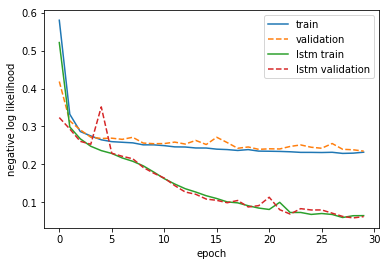

In [15]:
plt.plot(rnn_history.history['loss'], label='train')
plt.plot(rnn_history.history['val_loss'], '--', label='validation')
plt.plot(lstm_history.history['loss'], label='lstm train')
plt.plot(lstm_history.history['val_loss'], '--', label='lstm validation')
plt.ylabel('negative log likelihood')
plt.xlabel('epoch')
plt.legend(loc='best');

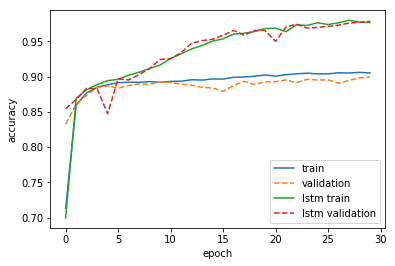

In [16]:
plt.plot(rnn_history.history['acc'], label='train')
plt.plot(rnn_history.history['val_acc'], '--', label='validation')
plt.plot(lstm_history.history['acc'], label='lstm train')
plt.plot(lstm_history.history['val_acc'], '--', label='lstm validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best');

In [ ]:
# Create a helper function that can take a Python
# iterable as input and applies each of the models
# to it, printing a human friendly version of the result

In [ ]:
# Modify the model construction function so that it
# can use a GRU layer as well. How does the GRU
# compare to the LSTM and Simple RNN?

In [ ]:
# Experiment with longer sequences.
# When do things stop working?
# How does the accuracy on the test set behave
# as a function of sequence length?

In [18]:
rnn.predict(X_test[:5])

array([[8.9403522e-01, 1.0596478e-01],
       [9.6727699e-01, 3.2722980e-02],
       [9.1677642e-01, 8.3223537e-02],
       [9.9965203e-01, 3.4801522e-04],
       [9.9946386e-01, 5.3611689e-04]], dtype=float32)

In [19]:
y_test[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [20]:
rnn.evaluate(X_test, y_test)

5066/5066 [==============================] - 0s 69us/step


[0.23871791721025665, 0.8969601263324122]